In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import time 
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
sns.set(color_codes=True)
from sklearn.preprocessing import MinMaxScaler

## Data Cleaning

In [8]:
rawData = pd.read_csv('data/SqlMetric_prepared.csv')
rawData.head()

,Event Name,Time MSec,Process Name,criteria,DURATION_MSEC,metrics,timestamp,usn,viewName,ActivityID
0,UIServerEventSource/LoadDataStart/Start,2518.457,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
1,UIServerEventSource/LoadDataStop/Stop,2621.028,Process(2920) (2920),Key_backup_policy_tag_73391121-b001-4a9a-b2b2-...,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0,NaN
2,UIServerEventSource/LoadDataStart/Start,2621.106,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
3,UIServerEventSource/LoadDataStop/Stop,2700.351,Process(2920) (2920),Key_@row_session_id_00000000-0000-0000-0000-00...,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1,NaN
4,UIServerEventSource/LoadDataStart/Start,2700.375,Process(2920) (2920),Key,NaN,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2,NaN


In [9]:
rawData.drop(['ActivityID', 'Event Name', 'criteria', 'Process Name'], axis=1, inplace=True)

In [10]:
rawData.isnull().sum()

Time MSec             0
DURATION_MSEC    173975
metrics               0
timestamp             0
usn                   0
viewName              0
dtype: int64

In [11]:
rawData.dropna(inplace=True)
print(rawData.isnull().sum())
print('Dataset shape: {}'.format(rawData.shape))

Time MSec        0
DURATION_MSEC    0
metrics          0
timestamp        0
usn              0
viewName         0
dtype: int64
Dataset shape: (173974, 6)


In [12]:
rawData.head()

,Time MSec,DURATION_MSEC,metrics,timestamp,usn,viewName
1,2621.028,102.572,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_0
3,2700.351,79.245,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_1
5,2701.448,1.073,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_2
7,6288.764,"3,587.28",Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,0,Procedure_3
9,6386.315,97.403,Table_1:47 Table_2:476 Table_3:199 Table_4:56,11/15/2019 9:51,"76,986",Procedure_4


In [ ]:
rawData['db_state'] = rawData['metrics'].apply(lambda x: x.split(' '))
rawData.drop(['metrics'], axis=1, inplace=True)
print('Dataset shape: {}'.format(rawData.shape))
row = rawData.iloc[0,5]
print('Metrics: {}'.format(row))

dic = {}

for st in row:
    splitted = st.split(':')
    key = splitted[0] 
    dic[key] = [] 
    
print('Parsing sql metrics')
for index, row in rawData.iterrows():
    metrics_row = row['db_state']
    for i in range(0,4):
        st = metrics_row[i]
        splitted = st.split(':')
        key = 'Table_{}'.format(i+1)
        val = np.NaN   
        if len(splitted)>1:
            val = int(splitted[1])
        
        dic[key].append(val)
        

print('Adding new metrics collumns')     
for key in dic.keys():
    rawData[key] = dic[key]

print('Drop db_state column')
rawData.drop(['db_state'], axis=1, inplace=True)
    
print('Parsing sql metrics finnised')
print('Dataset shape: {}'.format(rawData.shape))

Dataset shape: (173974, 6)
Metrics: ['Table_1:47', 'Table_2:476', 'Table_3:199', 'Table_4:56']
Parsing sql metrics


In [ ]:
print(rawData.isnull().sum())

In [ ]:
rawData.dropna(inplace=True)
print('Dataset shape: {}'.format(rawData.shape))

In [ ]:
rawData = rawData.applymap(lambda x: x.replace(',','') if type(x) is str or type(x) is object else x)
rawData['is_cold_start'] = rawData['usn'].apply(lambda x: True if int(x) == 0 else False)
rawData.drop(['usn', 'timestamp'], axis=1, inplace=True)
rawData.rename(columns={'Time MSec': 'timestamp', 'DURATION_MSEC': 'duration'}, inplace=True)
rawData['duration'] = rawData['duration'].apply(lambda x: float(x))
print(rawData.isnull().sum())
rawData.head()

In [11]:
rawData.shape

(169130, 8)

## Studing data

In [111]:
data = rawData[rawData.is_cold_start == True]

In [112]:
data.shape

(109069, 8)

In [113]:
data.describe()

,timestamp,duration,Table_1,Table_2,Table_3,Table_4
count,1.090690e+05,109069.000000,109069.0,109069.000000,109069.000000,109069.0
mean,7.477488e+07,83.171742,47.0,2576.190072,544.013588,56.0
std,4.090001e+07,256.800214,0.0,936.460447,84.732565,0.0
min,2.621028e+03,0.967000,47.0,476.000000,196.000000,56.0
25%,4.089169e+07,9.178000,47.0,1923.000000,555.000000,56.0
50%,7.391740e+07,23.392000,47.0,2662.000000,559.000000,56.0
75%,1.099937e+08,72.967000,47.0,3356.000000,595.000000,56.0
max,1.461257e+08,8106.180000,47.0,4075.000000,596.000000,56.0


In [114]:
top_proc_names = data.groupby('viewName')['viewName'].count().sort_values(ascending=False)
top_proc_names = top_proc_names.where(top_proc_names>5000).dropna()
top_proc_names

viewName
Procedure_2    36356.0
Procedure_1    36356.0
Procedure_0    36356.0
Name: viewName, dtype: float64

In [115]:
#Get only data with high std
poi = data[['viewName','timestamp','duration','Table_2','Table_3']]
poi.head()

,viewName,timestamp,duration,Table_2,Table_3
1,Procedure_0,2621.028,102.572,476.0,199.0
3,Procedure_1,2700.351,79.245,476.0,199.0
5,Procedure_2,2701.448,1.073,476.0,199.0
7,Procedure_3,6288.764,3587.280,476.0,199.0
23,Procedure_0,11830.785,12.070,476.0,199.0


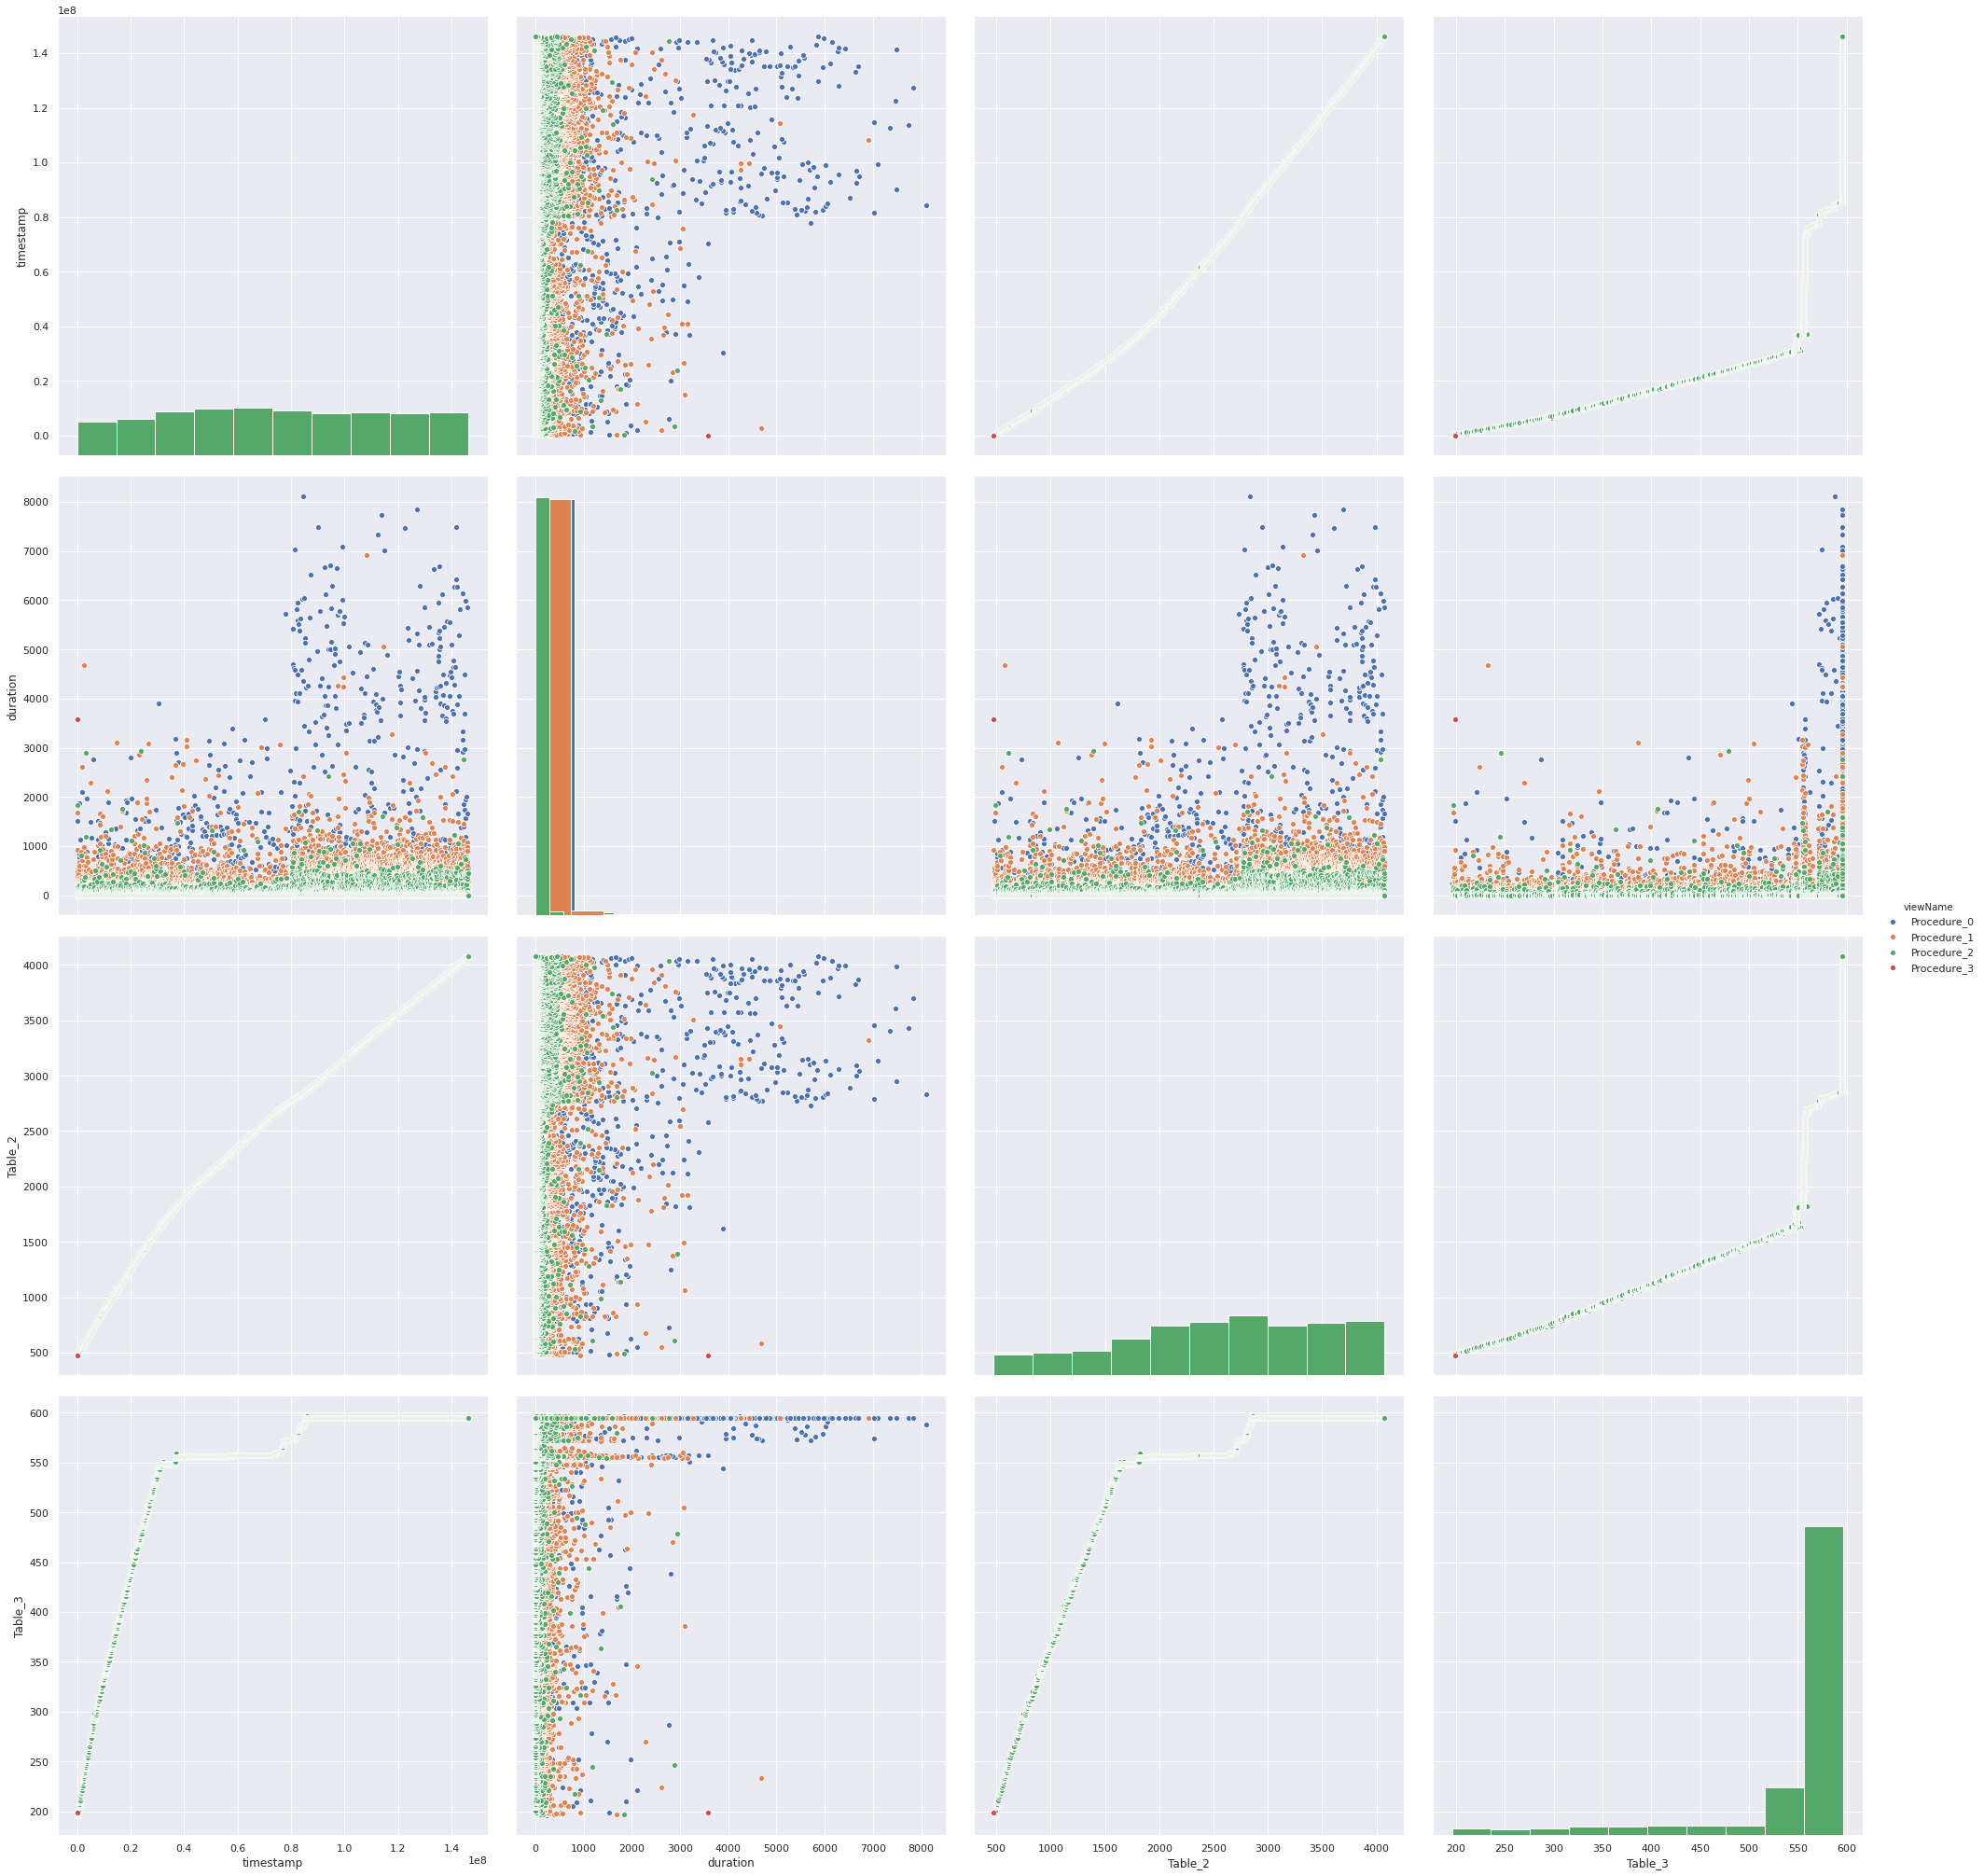

In [117]:
sns.pairplot(poi, hue='viewName', height=7,diag_kind='hist');

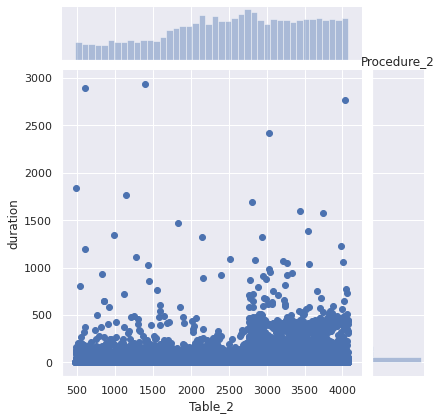

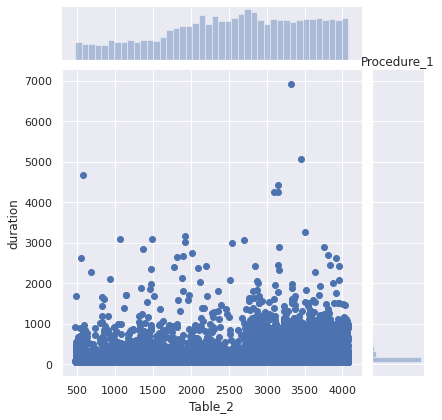

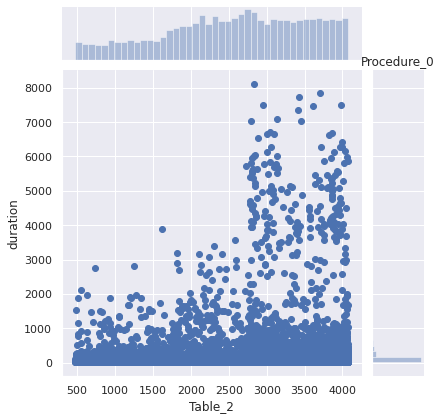

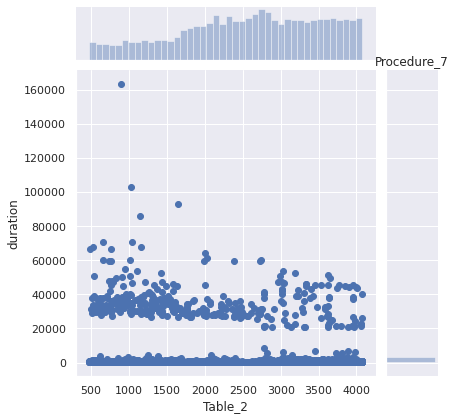

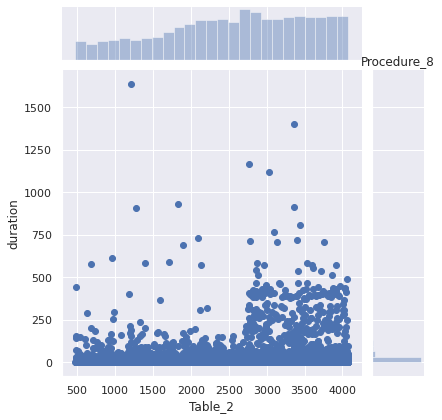

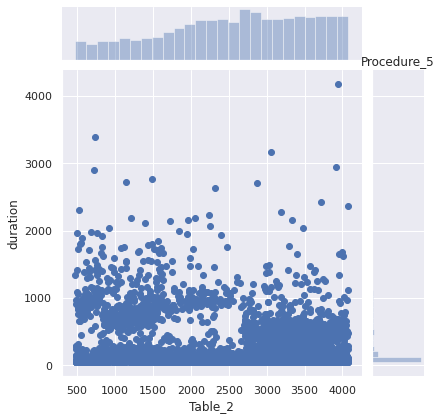

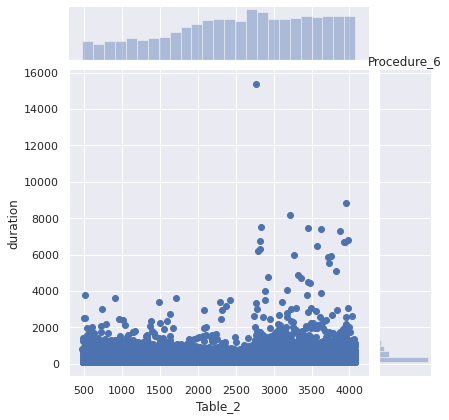

In [71]:
for index, value in top_proc_names.items():
    df = poi[poi.viewName == str(index)]
    sns.jointplot(x="Table_2", y="duration", data=df);
    plt.title(index)

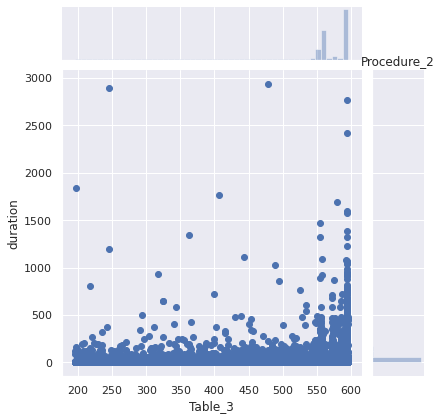

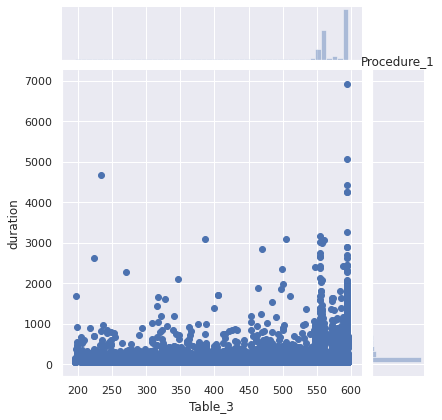

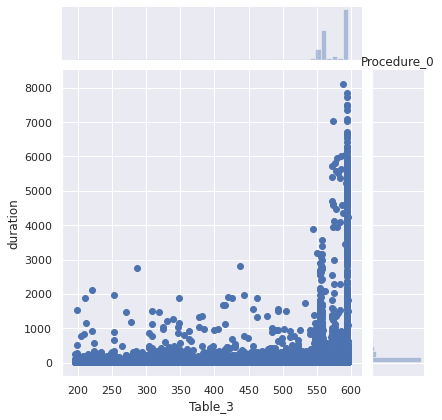

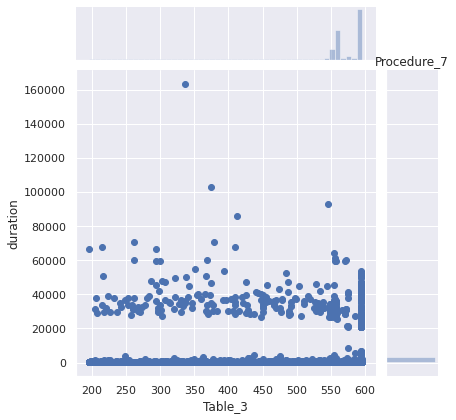

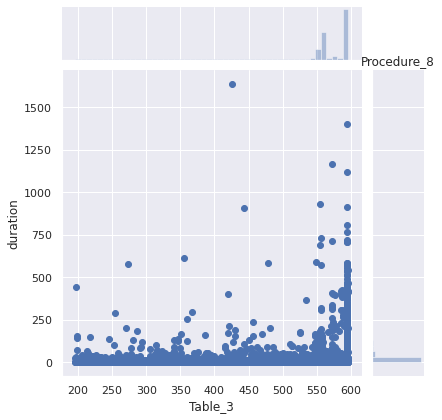

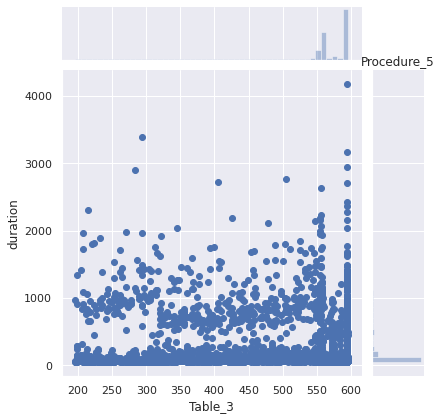

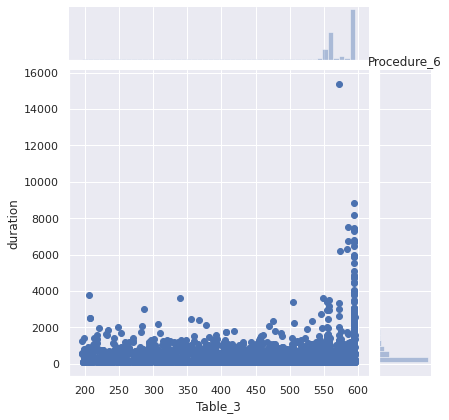

In [72]:
for index, value in top_proc_names.items():
    df = poi[poi.viewName == str(index)]
    sns.jointplot(x="Table_3", y="duration", data=df);
    plt.title(index)

In [73]:
poi.loc[:, 'second'] = poi.timestamp.apply(lambda x: round(x/1000))
time_series = poi[poi.Table_2>2500].groupby('second').size()
time_series

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


second
66701     3
66702     3
66705     4
66708     5
66711     3
         ..
146115    5
146118    7
146122    9
146125    1
146126    2
Length: 29950, dtype: int64

In [78]:
intensive_poi = poi.loc[poi['Table_2']>2500, :]
intensive_poi.head()

,viewName,timestamp,duration,Table_2,Table_3,second
154009,Procedure_0,66701411.66,9.386,2501.0,557.0,66701
154011,Procedure_1,66701494.64,82.901,2501.0,557.0,66701
154013,Procedure_2,66701497.33,2.668,2501.0,557.0,66701
154015,Procedure_5,66701548.50,51.086,2501.0,557.0,66702
154017,Procedure_6,66701629.09,80.502,2501.0,557.0,66702


In [79]:
#for index, value in top_proc_names.items():
#    name = 'viewName_{}'.format(index)
#    intensive_poi_p = intensive_poi.loc[intensive_poi[name]==1, :]
#    sns.jointplot(x="Table_3", y="duration", data= intensive_poi_p);
#    plt.title(index)

In [118]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [119]:
poi = pd.get_dummies(poi, prefix_sep='_', drop_first=True)
poi.head()

,timestamp,duration,Table_2,Table_3,viewName_Procedure_1,viewName_Procedure_2,viewName_Procedure_3
1,2621.028,102.572,476.0,199.0,0,0,0
3,2700.351,79.245,476.0,199.0,1,0,0
5,2701.448,1.073,476.0,199.0,0,1,0
7,6288.764,3587.280,476.0,199.0,0,0,1
23,11830.785,12.070,476.0,199.0,0,0,0


In [5]:
df_pois_clu = pd.DataFrame(poi, copy = True)
scaler = MinMaxScaler()
df_pois_clu_scaled=scaler.fit_transform(df_pois_clu)
outlier_detection = DBSCAN(
 eps = .2, 
 metric='euclidean', 
 min_samples = 5,
 n_jobs = -1)
clusters = outlier_detection.fit_predict(df_pois_clu_scaled)

NameError: name 'poi' is not defined

In [1]:
clusters

NameError: name 'clusters' is not defined

In [84]:
df_pois_clu = pd.DataFrame(poi, copy = True)
scaler = MinMaxScaler()

df_pois_clu_scaled=scaler.fit_transform(df_pois_clu)

start_time = time.time()
km_scores = []
db_score =[]
max_num_of_clu = 10
km_score_ = 0
for n in range(2,2+max_num_of_clu):
    cluster = KMeans(n_clusters=n).fit(df_pois_clu_scaled)
    clu = cluster.predict(df_pois_clu_scaled)
    km_scores.append(-cluster.score(df_pois_clu_scaled))
    
print('Clustering completed in {:,.2f} secs'.format(time.time()-start_time))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Clustering completed in 165.24 secs


<AxesSubplot:>

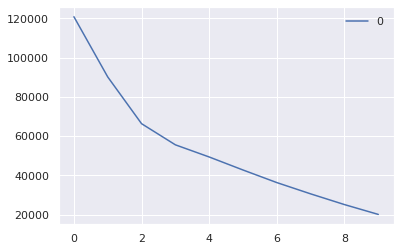

In [85]:
km_scores_df = pd.DataFrame(km_scores)
sns.lineplot(data=km_scores_df)

In [86]:
start_time = time.time()

clu_num = 3
df_pois_clu = pd.DataFrame(poi, copy = True)
scaler = MinMaxScaler()
df_pois_clu_scaled=scaler.fit_transform(df_pois_clu)

cluster = KMeans(n_clusters=clu_num).fit(df_pois_clu_scaled)
clu = cluster.predict(df_pois_clu_scaled)

poi['Cluster'] = clu

print('Clustering completed in {:,.2f} secs'.format(time.time()-start_time))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Clustering completed in 10.34 secs


In [87]:
poi.head()

,timestamp,duration,Table_2,Table_3,second,viewName_Procedure_1,viewName_Procedure_10,viewName_Procedure_2,viewName_Procedure_3,viewName_Procedure_4,viewName_Procedure_5,viewName_Procedure_6,viewName_Procedure_7,viewName_Procedure_8,viewName_Procedure_9,Cluster
1,2621.028,102.572,476.0,199.0,3,0,0,0,0,0,0,0,0,0,0,1
3,2700.351,79.245,476.0,199.0,3,1,0,0,0,0,0,0,0,0,0,2
5,2701.448,1.073,476.0,199.0,3,0,0,1,0,0,0,0,0,0,0,0
7,6288.764,3587.280,476.0,199.0,6,0,0,0,1,0,0,0,0,0,0,1
9,6386.315,97.403,476.0,199.0,6,0,0,0,0,1,0,0,0,0,0,1


In [88]:
poi.groupby('Cluster')

In [89]:
for i in range(0,3):
    clu0 = poi[poi.Cluster==i]
    print(clu0.describe())

          timestamp      duration       Table_2       Table_3         second  \
count  3.635600e+04  36356.000000  36356.000000  36356.000000   36356.000000   
mean   7.477562e+07     17.291678   2576.210969    544.016944   74775.617807   
std    4.089995e+07     67.382470    936.451706     84.726928   40899.948524   
min    2.701448e+03      0.967000    476.000000    196.000000       3.000000   
25%    4.089447e+07      1.463000   1923.000000    555.000000   40894.250000   
50%    7.391965e+07      3.384500   2662.000000    559.000000   73919.500000   
75%    1.099948e+08      9.337750   3356.000000    595.000000  109995.000000   
max    1.461257e+08   2933.200000   4075.000000    596.000000  146126.000000   

       viewName_Procedure_1  viewName_Procedure_10  viewName_Procedure_2  \
count               36356.0                36356.0               36356.0   
mean                    0.0                    0.0                   1.0   
std                     0.0                    0.0 